# Testing **FINBETO**, the previously trained model, with new dataset.

## 1. Importing required libraries

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import torch
from peft import PeftModel
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\Users\eucli\anaconda3\envs\FinancialNewsSentimentAnalysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Loading Dataset

In [2]:
df = pd.read_csv('../data/raw/financial_news_headlines_20250826.csv')
df.head(10)

,title,url,source,posting_date,target_sentiment
0,De deudas de tarjetas de crédito y el panameño...,https://panamabankingnews.com/columna-de-opini...,Panama Banking News,"agosto 26, 2025",Negative
1,"FMI prevé repunte económico en Panamá en 2025,...",https://panamabankingnews.com/economia/fmi-pre...,Panama Banking News,"agosto 26, 2025",Positive
2,Préstamos de autos mantienen la morosidad más ...,https://panamabankingnews.com/banca/prestamos-...,Panama Banking News,"agosto 22, 2025",Positive
3,Seguridad cuántica está acelerando la protecci...,https://panamabankingnews.com/notas-de-prensa/...,Panama Banking News,"agosto 22, 2025",Positive
4,Líderes regionales intercambiarán en Panamá he...,https://panamabankingnews.com/notas-de-prensa/...,Panama Banking News,"agosto 21, 2025",Positive
5,Nestlé Panamá entra en la cancha con sus marca...,https://panamabankingnews.com/notas-de-prensa/...,Panama Banking News,"agosto 19, 2025",Positive
6,Panamá reduce su prima de riesgo a mínimos de ...,https://panamabankingnews.com/economia/panama-...,Panama Banking News,"agosto 16, 2025",Positive
7,Panamá y Ecuador firman acuerdo tributario par...,https://panamabankingnews.com/economia/panama-...,Panama Banking News,"agosto 15, 2025",Positive
8,Presidente anuncia medidas para proteger la pr...,https://panamabankingnews.com/economia/preside...,Panama Banking News,"agosto 15, 2025",Positive
9,Presidente Mulino se reúne con ejecutivos del ...,https://panamabankingnews.com/economia/preside...,Panama Banking News,"agosto 15, 2025",Positive


## 3. Loading FINBETO and preparing the inference pipeline 

In [11]:
device = 0 if torch.cuda.is_available() else -1
lora_model_name = "EuclidesHernandez/finbeto"

# Load the base model and the LoRA-adapted model
tokenizer = AutoTokenizer.from_pretrained(lora_model_name)
model = AutoModelForSequenceClassification.from_pretrained(lora_model_name, num_labels=3)

# Create the text classification pipeline
classifier = pipeline(
    "text-classification",    
    model=model,
    tokenizer=tokenizer,
    device=device
)
# Prepare the financial news articles for inference
financial_news = df['title'].tolist()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


## 4. Running the pipeline

In [12]:
print(f"Running inference on {len(financial_news)} news...")
predictions = classifier(financial_news, batch_size=16, truncation=True)
print("Inference complete.")


Running inference on 63 news...
Inference complete.


## 5. Analyzing the results of the predictions

In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_predictions = f'../tests/inference/test_predictions_{timestamp}.csv'
df['predicted_label'] = [p['label'] for p in predictions]
df['confidence_score'] = [p['score'] for p in predictions]
df.to_csv(output_predictions, index=False)

## 6. Plotting inference results

In [15]:
# Mapping predicted labels to their corresponding sentiment
label_mapping = {
    'LABEL_0': 'Positive',
    'LABEL_1': 'Negative',
    'LABEL_2': 'Neutral'
}
df['predicted_label'] = df['predicted_label'].map(label_mapping)

# Preparing actual labels and predicted labels for evaluation
y_true = df['target_sentiment']
y_pred = df['predicted_label']

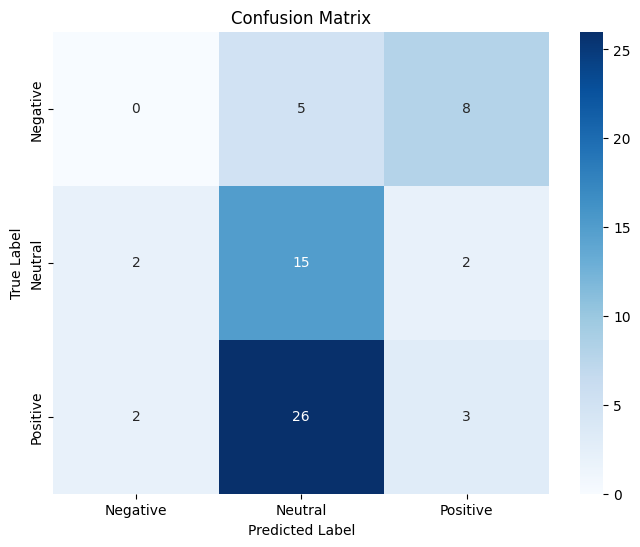

In [16]:
# Plotting confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_labels = np.unique(y_true)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        13
     Neutral       0.33      0.79      0.46        19
    Positive       0.23      0.10      0.14        31

    accuracy                           0.29        63
   macro avg       0.19      0.30      0.20        63
weighted avg       0.21      0.29      0.21        63

